# Multiclass classification 3: Tune and save

This notebook comes after:

- Multiclass_classification_1_Split_and_scale.ipynb
- Multiclass_classification_2_Fit_and_score.ipynb

This notebook assumes you have some familiarity with:

- Basic Python syntax and functions.
- Numerics and visualization with NumPy and `matplotlib` or `seaborn`.
- Exploratory data analysis with Pandas.
- The essential concepts of supervised machine learning.
- The fundamentals of machine learning algorithms.

If you're a bit short on a couple of these elements, not to worry. There are other courses that cover them, but you might find that we breeze past some topics in this class. Ask questions and follow links!

---

## Unfreezing the data

In [3]:
import numpy as np

f = np.load("All_data.npz", allow_pickle=True)
X_train, X_test, y_train, y_test, wells = [f.get(file) for file in f.files]

X_train[:5]

array([[7.74500000e+01, 2.39349994e+03, 4.60000000e+00, 6.64000000e-01],
       [7.82600000e+01, 2.41611981e+03, 4.10000000e+00, 6.61000000e-01],
       [7.90500000e+01, 2.40457606e+03, 3.60000000e+00, 6.58000000e-01],
       [8.61000000e+01, 2.39324907e+03, 3.50000000e+00, 6.55000000e-01],
       [7.45800000e+01, 2.38260260e+03, 3.40000000e+00, 6.47000000e-01]])

In [4]:
import sklearn

print(sklearn.__version__)

# Make sure we can see all of the model details.
sklearn.set_config(print_changed_only=False)

0.24.2


## Tuning models to improve performance

Depending on you requirements, this results might be good enough to deploy this model and use it in production but it is usually not the best model you can get. Each method has a set of controls or arguments, known as _hyperparameters_, that can be tweaked to tune the training.

Note that we don't call these settings 'parameters' because that word is reserved for the learnable parameters, weights, or coefficients in the model (e.g. $\mathbf{w}$ and $b$ in $\hat{y} = \mathbf{w}\mathbf{x} + b$).

For the `SVC` there are a few of these hyperparameters:

In [5]:
from sklearn.svm import SVC

SVC()

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Note that by default, the SVM applies regularization (unlike the usual alpha, the C hyperparameter is **inversely** proportional to the amount of regularization, so use low C for smoother models), and kernel transformations (fitting non-linearly separable data).

For this particular algorithm, the most important hyperparameters are:

- `kernel`: especially linear vs nonlinear.
- `C`, the regularization parameter.
- `gamma`, the kernel coefficient for nonlinear kernels.
- `degree`, for polynomials kernels only.

For the time being, we'll use the default nonlinear kernel and concentrate on finding the best value of `C`, the regularization parameter.

Recall our basic model:

In [66]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report

m = make_pipeline(StandardScaler(), SVC())
y_pred = cross_val_predict(m, X_train, y_train, cv=LeaveOneGroupOut(), groups=wells)
print(classification_report(y_train, y_pred, digits=3))

              precision    recall  f1-score   support

    dolomite      0.481     0.160     0.241        81
   limestone      0.661     0.653     0.657       551
    mudstone      0.359     0.176     0.236       375
   sandstone      0.000     0.000     0.000       170
   siltstone      0.713     0.954     0.816      1141
  wackestone      0.431     0.465     0.448       391

    accuracy                          0.631      2709
   macro avg      0.441     0.401     0.400      2709
weighted avg      0.561     0.631     0.582      2709



In order to get at scores during the cross-validation process, we could use `cross_val_score()` (see previous notebook), but `cross_validate()` is even more general:

In [12]:
from sklearn.model_selection import cross_validate

cross_validate(m, X_train, y_train,
               cv=LeaveOneGroupOut(), groups=wells,
               scoring=['f1_weighted'], return_train_score=True,
               n_jobs=6
              )

{'fit_time': array([0.10070562, 0.09652448, 0.10319209, 0.09822989, 0.11598682,
        0.11035895]),
 'score_time': array([0.02539682, 0.0290823 , 0.03337884, 0.02870727, 0.02843237,
        0.03283978]),
 'test_f1_weighted': array([0.55035768, 0.31939337, 0.716337  , 0.60786152, 0.67110915,
        0.68657318]),
 'train_f1_weighted': array([0.70113673, 0.69664069, 0.6798503 , 0.69188605, 0.67676785,
        0.67236759])}

There are [a lot of different scoring parameters](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules) and you can even define your own.

Examples of classifier scoring metrics:

- `'accuracy'`
- `'average_precision'`
- `'f1_weighted'`
- `'roc_auc'`

...and a lot of others.

### EXERCISE

Let's see how the training and validation scores vary with `C`. Can you loop over values of `C` (it's an exponential property, so try using `np.logspace()` to make an array of values to test) &mdash; collect the train and CV weighted F1 scores, and make a plot of them vs the values of `C`.

You will probably want to use `ax.set_xscale('log')` to make the plot easier to read.

In [13]:
# YOUR CODE HERE



In [14]:
from sklearn.svm import SVC

C = np.logspace(-3, 3, 13)

all_vals = []
all_trains = []
for Ci in C:
    m = make_pipeline(StandardScaler(), SVC(C=Ci))
    scores = cross_validate(m, X_train, y_train,
                            cv=LeaveOneGroupOut(), groups=wells,
                            scoring=['f1_weighted'], return_train_score=True, n_jobs=6)
    all_vals.append(np.mean(scores['test_f1_weighted']))
    all_trains.append(np.mean(scores['train_f1_weighted']))

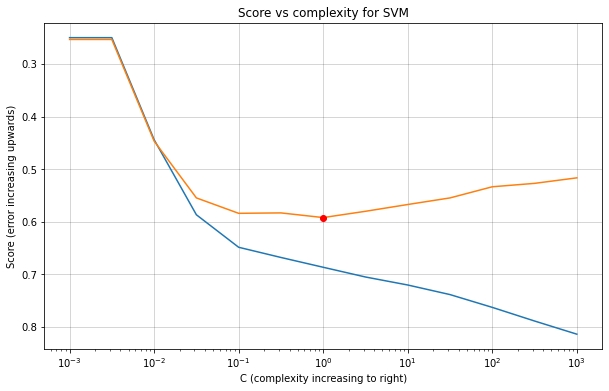

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(C, np.array(all_trains))
ax.plot(C, np.array(all_vals))
ax.plot(C[np.argmax(all_vals)], max(all_vals), 'ro')  # <-- The max val score.
ax.grid(c='k', alpha=0.2)
ax.set_xscale('log')
ax.invert_yaxis()
ax.set_xlabel('C (complexity increasing to right)')
ax.set_ylabel('Score (error increasing upwards)')
ax.set_title('Score vs complexity for SVM')
plt.show()

Looks like the range 0.1 to 1.0 is where we want to look. `C=1.0` also happens to be the default.

## ROC-AUC as a model selection tool

The **Area Under the Curve** (AUC) of the [**Receiver Operating Characteristic** (ROC)](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is another way to compare models (or versions of the model with different hyperparameter settings).

[Here's a great video about the AUC-ROC method.](https://www.youtube.com/watch?v=4jRBRDbJemM)

So let's take a look at the area under the ROC curve to look for the best value of `C`:

In [21]:
from sklearn.metrics import roc_auc_score

aucs = []

for Ci in C:
    m = make_pipeline(StandardScaler(), SVC(C=Ci, probability=True))
    y_prob = cross_val_predict(m, X_train, y_train,
                               cv=LeaveOneGroupOut(), groups=wells,
                               method='predict_proba', n_jobs=6)
    auc = roc_auc_score(y_train, y_prob, multi_class='ovo')
    aucs.append(auc)

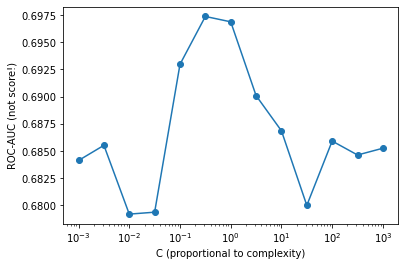

In [22]:
plt.plot(C, aucs, 'o-')
plt.ylabel('ROC-AUC (not score!)')
plt.xlabel('C (proportional to complexity)')
plt.xscale('log')

This supports the idea that 0.3 to 1.0 is a decent choice. So we can keep the default.

In [24]:
model = make_pipeline(StandardScaler(), SVC(C=1.0))
y_pred = cross_val_predict(model, X_train, y_train, cv=LeaveOneGroupOut(), groups=wells)
print(classification_report(y_train, y_pred, digits=3))

              precision    recall  f1-score   support

    dolomite      0.481     0.160     0.241        81
   limestone      0.661     0.653     0.657       551
    mudstone      0.359     0.176     0.236       375
   sandstone      0.000     0.000     0.000       170
   siltstone      0.713     0.954     0.816      1141
  wackestone      0.431     0.465     0.448       391

    accuracy                          0.631      2709
   macro avg      0.441     0.401     0.400      2709
weighted avg      0.561     0.631     0.582      2709



---

## Choosing the right estimator

Often the hardest part of solving a machine learning problem can be finding the right estimator for the job.

This is a good place to start ([here](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) is a clickable version):

<img src="https://scikit-learn.org/stable/_static/ml_map.png"></img>

---

Different estimators are better suited for different types of data and different problems. For a classifier comparison (below) check the source code [here](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_classifier_comparison_001.png"></img>

### [Check out this paper with a comparison of many classifiers](https://arxiv.org/abs/1708.05070)

### Exercise

- Can you beat our current high score by twiddling hyperparameters on one of these models?
- Or, try other methods available in the scikit-learn library. See the list [here](http://scikit-learn.org/stable/supervised_learning.html). For example, get a sneak peek at neural nets with the MLP.

In [ ]:
# YOUR CODE HERE



----

## Hyperparameter tuning

Many of the models can be improved (or worsened) by changing the parameters that internally make the method work. It's always a good idea to check the documentation of each model (e.g. `RandomForestClassifier` [docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). This process is usually called _hyperparameter tuning_.

Scikit-learn offers a convenient way to test multiple parameters for each model through a function called `GridSearchCV`.

As with other cross validation tools in `sklearn`, the default behviour is to split the training data randomly into _k_ 'folds'. But we'll define a 'LOGO' splitter as before.

In [114]:
np.linspace(0.05, 1, 20)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [115]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

model = Pipeline(steps=[('scaler', StandardScaler()),
                        ('svc', SVC()),
                       ])

param_grid = {'svc__C': np.logspace(-4, 2, 13),
              'svc__gamma': np.linspace(0.05, 1, 20),
             }
             
clf = GridSearchCV(model, param_grid,
                   scoring='f1_weighted',
                   cv=LeaveOneGroupOut(),
                   n_jobs=6, verbose=1,
                  )

clf.fit(X_train, y_train, groups=wells)

Fitting 6 folds for each of 260 candidates, totalling 1560 fits


GridSearchCV(cv=LeaveOneGroupOut(), error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_state=None, shri...
             param_grid={'svc__C': array([1.

In [116]:
clf.cv_results_

{'mean_fit_time': array([0.17289086, 0.17315976, 0.18308051, 0.18928572, 0.18452617,
        0.18766399, 0.17938741, 0.19035029, 0.23365525, 0.23100003,
        0.19131132, 0.19038761, 0.20429782, 0.3458569 , 0.47616831,
        0.276227  , 0.23763267, 0.23884078, 0.24868035, 0.25189424,
        0.2445786 , 0.25214458, 0.25882602, 0.26196055, 0.26602062,
        0.30474091, 0.34435189, 0.32421498, 0.35206401, 0.34075173,
        0.340487  , 0.31354725, 0.31622601, 0.29751877, 0.29092113,
        0.3080465 , 0.27229548, 0.29632012, 0.32446706, 0.28978666,
        0.24132188, 0.24699048, 0.24746068, 0.2440141 , 0.25669177,
        0.27695004, 0.28490965, 0.27808559, 0.26205456, 0.25180785,
        0.24596906, 0.26270783, 0.24201012, 0.25182867, 0.24653856,
        0.24953381, 0.23940937, 0.23712313, 0.23661935, 0.23367059,
        0.23330923, 0.23416785, 0.2369225 , 0.24039431, 0.23404562,
        0.26973395, 0.26248535, 0.24344981, 0.23993329, 0.24474152,
        0.25265531, 0.23570414,

Let's see how we do on each well as we omit it from the training in turn:

In [117]:
for i, well in enumerate(np.unique(wells)):
    scores = clf.cv_results_[f'split{i}_test_score']
    print(f"{well:>16s} ... {np.mean(scores):.4f}")

 CHURCHMAN BIBLE ... 0.3713
  CROSS H CATTLE ... 0.2822
        LUKE G U ... 0.5550
           NEWBY ... 0.4256
           NOLAN ... 0.5184
       SHRIMPLIN ... 0.5484


How does the parameter space look with respect to the score of the classifier?

This works for one log-distributed property, e.g. C.

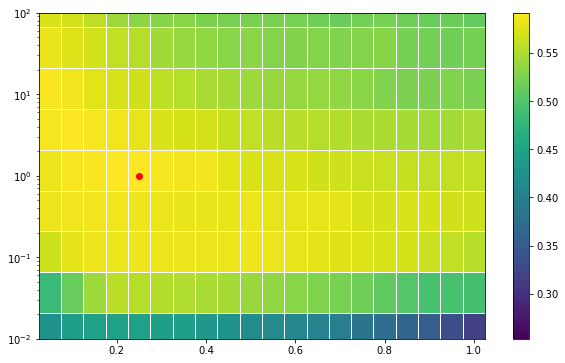

In [127]:
scores = clf.cv_results_['mean_test_score']
shape = [len(s) for s in param_grid.values()][:2]
ys = list(param_grid.values())[0]
xs = list(param_grid.values())[1]
X,Y = np.meshgrid(xs, ys)
Z = scores.reshape(shape)

plt.figure(figsize=(10, 6))
plt.pcolormesh(X, Y, Z, shading='auto', ec='w')
plt.yscale('log')
plt.ylim(1e-2, 1e2)
plt.plot(list(clf.best_params_.values())[1],
        list(clf.best_params_.values())[0],
        'ro')
plt.colorbar()

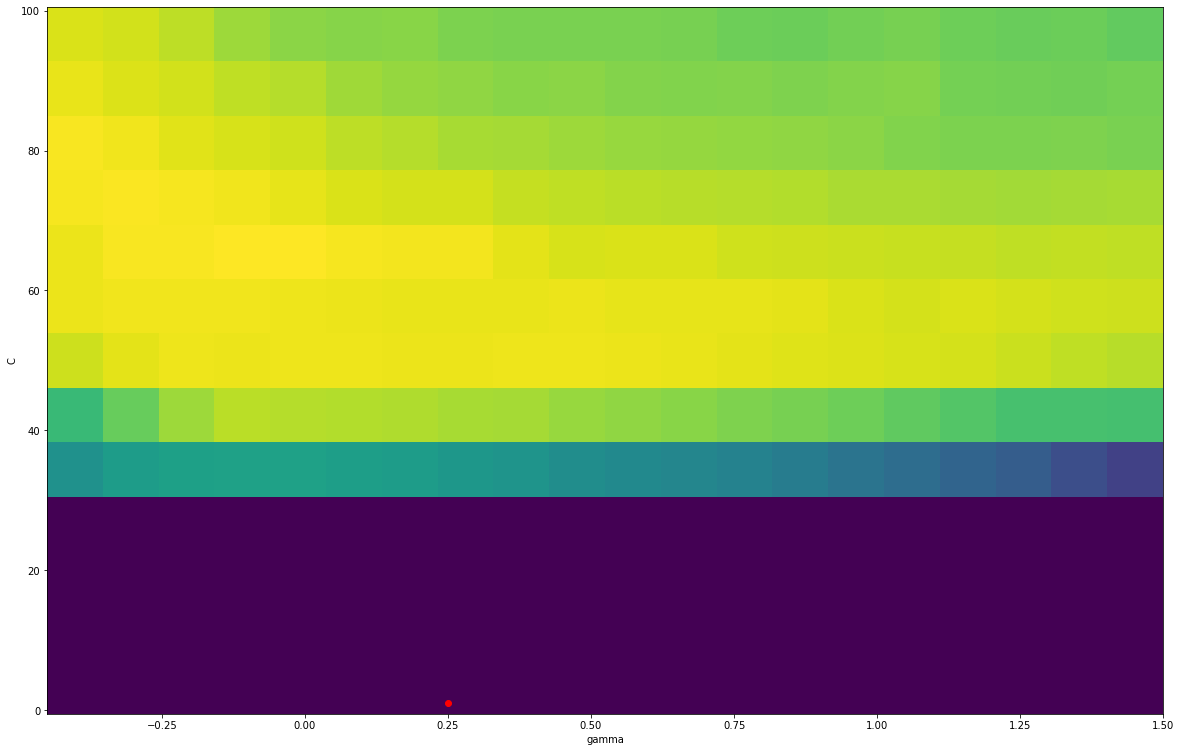

In [119]:
scores = clf.cv_results_['mean_test_score']

shape = [len(s) for s in param_grid.values()][:2]
minx, *_, maxx = list(param_grid.values())[1]
miny, *_, maxy = list(param_grid.values())[0]

fig, ax = plt.subplots(figsize=shape[::-1])
im = ax.imshow(scores.reshape(shape),
               origin='lower',
               extent=[minx-0.5, maxx+0.5, miny-0.5, maxy+0.5],
               interpolation='none',
               aspect='auto',
               cmap='viridis')
ax.set_xlabel(list(clf.best_params_.keys())[1].split('__')[1])
ax.set_ylabel(list(clf.best_params_.keys())[0].split('__')[1])
ax.plot(list(clf.best_params_.values())[1],
        list(clf.best_params_.values())[0],
        'ro')

`clf` can now tell us the best parameters to use with our `SVC` classifier:

In [120]:
clf.best_params_

{'svc__C': 1.0, 'svc__gamma': 0.25}

In [121]:
clf.best_estimator_

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.25, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [122]:
clf.best_score_

0.591938648735305

## Test the model

Now might be a good time to check our **test** set — the one we reserved at the start. How might our model do on this dataset?

In [123]:
from sklearn.metrics import f1_score

f1_score(y_test, clf.predict(X_test), average='weighted')

0.524481354036701

We get a similar result to what we were getting in validation. That's good.

The pipeline is convenient whenever we have multiple steps in the prediction workflow, because it ensures we'll be consistent and makes it easier to save the model (below).

## Training the final model

Now that we have selected the model we want to use, we should retrain it on all of the data.

NB We could omit the scaling step for a random forest. But it doesn't do any harm...

In [104]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

model = clf.best_estimator_.fit(X, y)

We don't have anything to test this on, but we expect it to achieve similar performance to that against the test set.

## Model persistence

Often, we'd like to save the trained model, to go and apply it in some other application, or to share with someone else. The easiest way to save most models is as a Python 'pickle' object:

In [105]:
import joblib

joblib.dump(model, 'facies_pipeline.pkl')

['facies_pipeline.pkl']

## Model application

How do you load and use a saved model?

In [106]:
model = joblib.load('facies_pipeline.pkl')

In [107]:
model.named_steps

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'svc': SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma=0.2, kernel='rbf',
     max_iter=-1, probability=False, random_state=None, shrinking=True,
     tol=0.001, verbose=False)}

Now you can load some data:

    df = pd.read_csv('..some_new_data_you_have_collected.csv')
  
Then extract the relevant features and cast it as a 2D array:

    X_new = df[['GR','RHOB','PE','ILD_log10']].values

Now pass the matrix `X_new` into the classifier's predict method:

    y_pred = model.predict(X_new)

And you're done!

<hr />

<p style="color:gray">©2021&ndash;2022 Agile Geoscience. Licensed CC-BY.</p>